<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pygeohash
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6153 sha256=ad413c2efd4ad7e3ebc6d61178d96c7a86b0f3cf589140e6d6df8f41090efcbd
  Stored in directory: /root/.cache/pip/wheels/28/ec/b6/beadf7295a623f528507691fb0d471b50d064ae9bbad420b8f
Successfully built pygeohash
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [39]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train_all_df.csv', index_col=0)

train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test_all_df.csv', index_col=0)

In [40]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [41]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [42]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


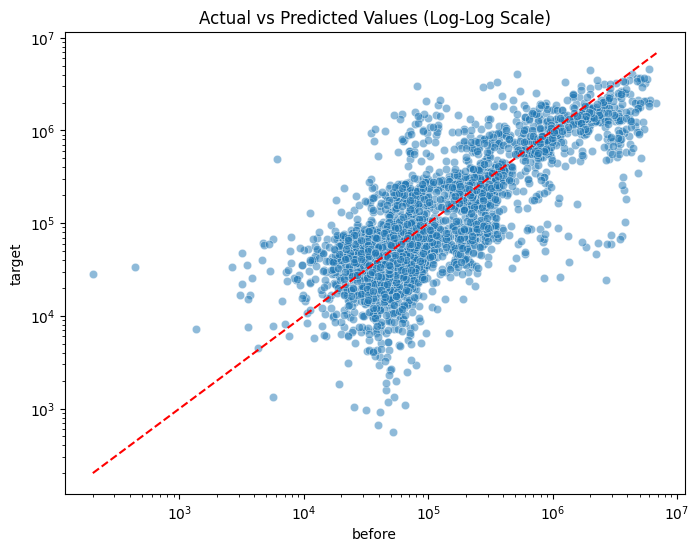

In [44]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

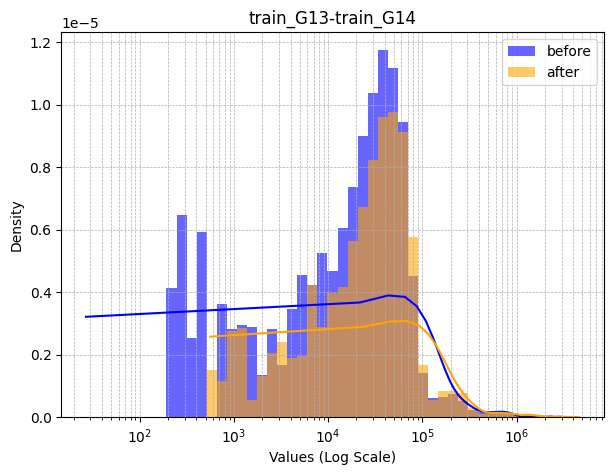

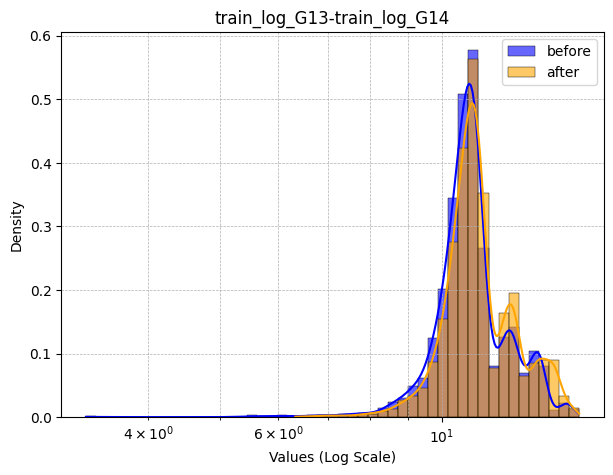

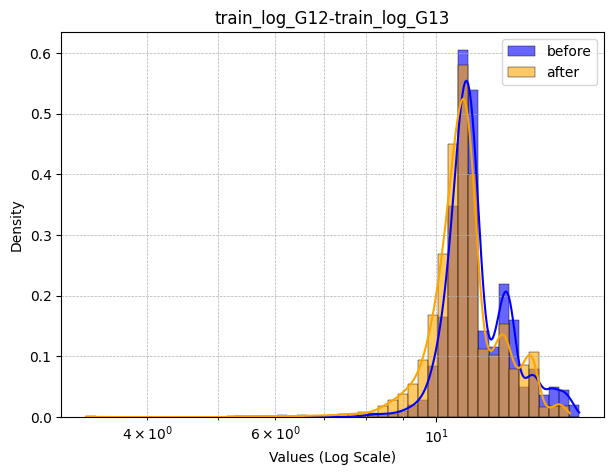

In [45]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [46]:
train = train_df.iloc[:, :-1].values
test = test_df.values
target = train_df.iloc[:, -1].values

'iterations': 254, 'depth': 5, 'learning_rate': 0.08377009991199288, 'l2_leaf_reg': 1, 'bagging_temperature': 0.7204457890870082, 'min_data_in_leaf': 4

In [70]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log1p(y_train))
            preds = np.expm1(model.predict(X_valid))
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)

        test_predictions += test_preds / kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions

In [71]:
oof_predictions,test_preds = get_models_trained(train,test,target,30)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.677951545682968
Fold 1 RMSLE for model2 = 0.6821591751949535
Fold 1 RMSLE for model3 = 0.6731740544381261
Fold 1 RMSLE for model4 = 0.6737453155587385
Fold 1 RMSLE for ('model1', 'model2') = 0.6781616158593328
Fold 1 RMSLE for ('model1', 'model3') = 0.6752482372649651
Fold 1 RMSLE for ('model1', 'model4') = 0.6750718384722373
Fold 1 RMSLE for ('model2', 'model3') = 0.6758642639978703
Fold 1 RMSLE for ('model2', 'model4') = 0.6765976180152198
Fold 1 RMSLE for ('model3', 'model4') = 0.6724771972737226
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.6759857264632863
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.6761808421770317
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.6740262419866304
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.674534721469946
Fold 1 RMSLE for all models ensemble = 0.6749889012942764
Fold 1 best combination: ('model3', 'model4') with RMSLE = 0.6724771972737226
---------------

Starting Fold 2
Fold 2 

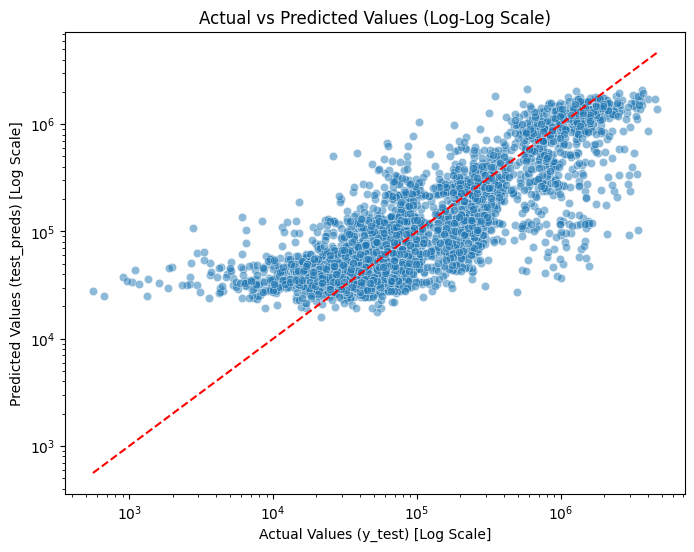

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
target = target.flatten()
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=target, y=oof_predictions, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--')  # 45度線
plt.show()

In [73]:
# train_all = np.concatenate((train, test), axis=0)
# target_all = np.concatenate((target, test_preds), axis=0)
# oof_predictions,test_preds = get_models_trained(train_all,test,target_all,30)

In [74]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,249574.303827
1,4656,249574.303827
2,4657,249574.303827
3,4658,249574.303827
4,4659,249574.303827
...,...,...
2503,7158,249574.303827
2504,7159,249574.303827
2505,7160,249574.303827
2506,7161,249574.303827


In [75]:
test_preds.shape

(2508,)

In [83]:
submit [ 1 ]  =  test_preds
submit.to_csv('SMBC_31.csv', index = False)


In [84]:
submit

,0,1
0,4655,4.391229e+04
1,4656,3.156506e+05
2,4657,4.140460e+04
3,4658,2.695807e+04
4,4659,4.698617e+04
...,...,...
2503,7158,5.857172e+05
2504,7159,1.283374e+05
2505,7160,1.305082e+05
2506,7161,2.689568e+05


In [85]:
test_df.iloc[:, -1]

,test_preds
0,4.365953e+04
1,3.184321e+05
2,4.060332e+04
3,2.760253e+04
4,4.707800e+04
...,...
2503,5.497954e+05
2504,1.137684e+05
2505,1.412656e+05
2506,2.599965e+05


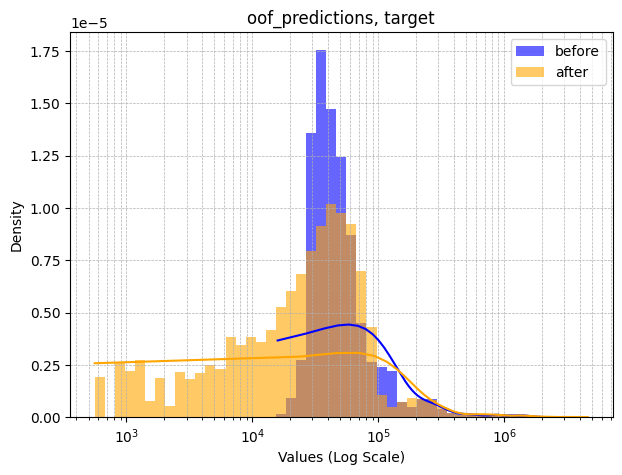

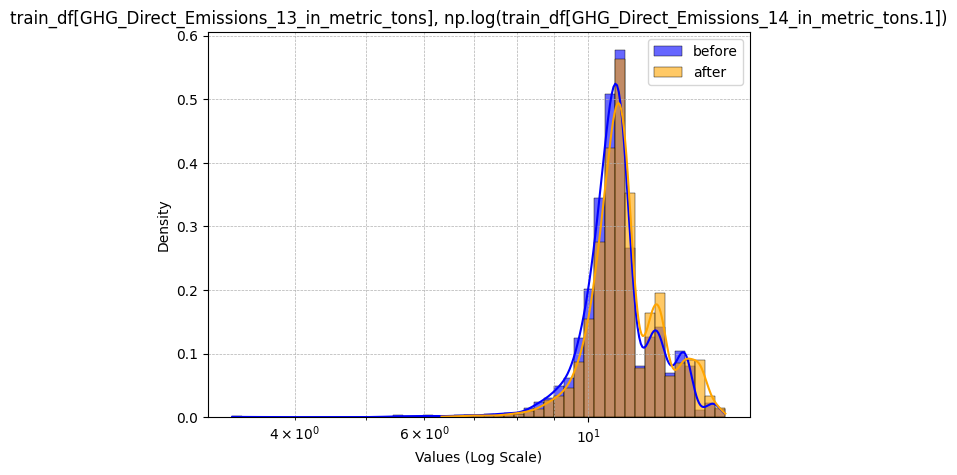

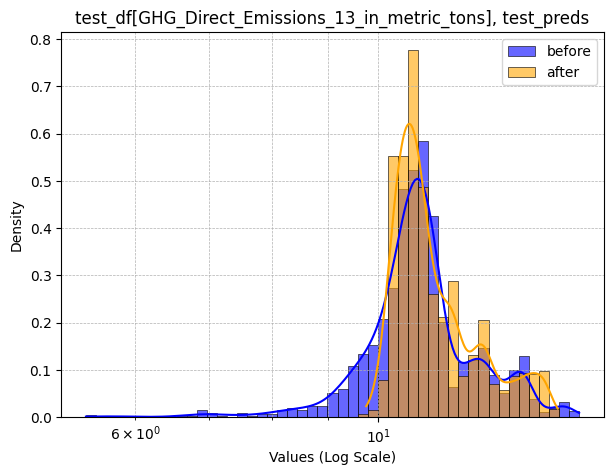

In [86]:

# show_plot(np.exp(oof_predictions), np.exp(target))
show_plot(oof_predictions, target, "oof_predictions, target")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_df[GHG_Direct_Emissions_13_in_metric_tons], np.log(train_df[GHG_Direct_Emissions_14_in_metric_tons.1])")
show_plot(np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(test_preds),
          "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")

In [87]:
import time
print(time.ctime())

Fri Nov 22 05:32:21 2024
